In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import skew, kurtosis, shapiro
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

def get_data(filter1: str, filter2: str):
    # Read the input data from the CSV file
    data = pd.read_csv('inputs.csv', parse_dates=['date']) # date,avg_efficiency,max_efficiency,open_price,count

    # keep only data after filter
    data = data[data['date'] >= filter1]
    data = data[data['date'] < filter2]

    # time variable: (year-2011)*12+month
    data['time'] = (data['date'].dt.year - 2011) * 12 + data['date'].dt.month

    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(method='bfill', inplace=True)

    # Create quarterly averages
    quarterly_data = data.resample('Q', on='date').mean()
    # Create monthly averages
    monthly_data = data.resample('M', on='date').mean()
    # Create weekly averages
    weekly_data = data.resample('W', on='date').mean()
    # Keep daily data
    daily_data = data

    quarterly_data['count'] = data.resample('Q', on='date').sum()['count']
    monthly_data['count'] = data.resample('M', on='date').sum()['count']
    weekly_data['count'] = data.resample('W', on='date').sum()['count']
    daily_data['count'] = data['count']

    for df in [quarterly_data,monthly_data, weekly_data, daily_data]:
        # Calculate the derivative of ln avg_efficiency
        df['ln_avg_efficiency'] = np.log(df['avg_efficiency'])
        df['d_ln_avg_efficiency'] = df['ln_avg_efficiency'].diff()

        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(method='bfill', inplace=True)

        # Differencing the series to make it stationary
        df['ln_open_price'] = np.log(df['open_price'])
        df['d_ln_open_price'] = df['ln_open_price'].diff().fillna(method='bfill')

    return quarterly_data,monthly_data, weekly_data, daily_data


results_df = None

from sklearn.preprocessing import MinMaxScaler

def plot_model(test_data, predictions, p, q, title='Model Estimation'):
    # Normalizing count and d_ln_avg_efficiency
    scaler = MinMaxScaler(feature_range=(-0.15, 0.15))
    normalized_values = scaler.fit_transform(test_data[['count', 'd_ln_avg_efficiency']])
    normalized_count = normalized_values[:, 0]
    normalized_d_ln_avg_efficiency = normalized_values[:, 1]
    
    # Plotting the predictions against the actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(test_data.index, test_data['d_ln_open_price'], label='Actual d_ln_open_price', color='blue', marker='o')
    plt.scatter(test_data.index, predictions, label='Predicted d_ln_open_price', color='red', marker='x')
    plt.plot(test_data.index, normalized_count, label='Normalized Count', color='green', linestyle='--')
    plt.plot(test_data.index, normalized_d_ln_avg_efficiency, label='Normalized d_ln_avg_efficiency', color='purple', linestyle='-.')
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Dashed line at y=0
    plt.title(f'{title} Predictions vs Actual, p={p}, q={q}')
    plt.xlabel('Date')
    plt.ylabel('diff of ln(open price) and Normalized Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.tight_layout()
    plt.show()

def add_constant(train_exog, test_exog):
    # train_exog["const"] = 1
    # test_exog["const"] = 1
    # # Ensure the shapes of train_exog and test_exog match
    # print(train_exog.columns)
    # print(test_exog.columns)
    return train_exog, test_exog

def get_stats(model_fit, test_data, test_exog):
    predictions = model_fit.forecast(steps=len(test_data), exog=test_exog)
    mse = mean_squared_error(test_data['d_ln_open_price'], predictions)
    rmse = np.sqrt(mse)
    aic = model_fit.aic
    bic = model_fit.bic
    
    # Test residuals for autocorrelation, normality, and heteroscedasticity
    residuals = model_fit.resid
    # Autocorrelation tests
    ljung_box = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
    durbin_watson = sm.stats.durbin_watson(residuals)
    # Normality tests
    jarque_bera = sm.stats.jarque_bera(residuals)
    shapiro_wilk = shapiro(residuals)
    # Heteroscedasticity test
    white_test = sm.stats.het_white(residuals, model_fit.model.exog)
    
    return {
        'MSE': mse, 'RMSE': rmse, 'AIC': aic, 'BIC': bic,
        'Ljung-Box': ljung_box['lb_pvalue'].values[0], 'Durbin-Watson': durbin_watson,
        'Jarque-Bera': jarque_bera[1], 'Shapiro-Wilk': shapiro_wilk[1],
        'White Test': white_test[1]
    }

# Adjust the model estimation to use the differenced series
def model_estimation(df, p_range, q_range, title='Model Estimation', ratio=0.8):
    global results_df
    results = []
    train_size = int(len(df) * ratio)
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]

    cols = ['d_ln_avg_efficiency']  #, 'count' ,'time']
    train_exog, test_exog = add_constant(train_data[cols], test_data[cols])

    for p in p_range:
        for q in q_range:
            try:
                # Perform rolling cross-validation
                rolling_mae = []
                for start in range(0, len(train_data) - 10, 5):  # Adjust these values as needed
                    end = start + 10  # Adjust for the size of the window
                    rolling_train = train_data.iloc[start:end]
                    rolling_test = train_data.iloc[end:end + 1]  # Predict one step ahead
                    rolling_train_exog, rolling_test_exog = add_constant(rolling_train[cols], rolling_test[cols])
                    model = ARIMA(rolling_train['d_ln_open_price'], order=(p, 0, q), exog=rolling_train_exog)
                    model_fit = model.fit()
                    predictions = model_fit.forecast(steps=1, exog=rolling_test_exog)
                    mae = mean_absolute_error(rolling_test['d_ln_open_price'], predictions)
                    rolling_mae.append(mae)
                avg_mae = np.mean(rolling_mae)
                results.append({'p': p, 'q': q, 'MAE': avg_mae})

            except Exception as e:
                print(f"Error with ARIMA({p},0,{q}): {e}")

    # sort results and print/plot only the top 3
    results = sorted(results, key=lambda x: x['MAE'])
    for i in range(3):
        p = results[i]['p']
        q = results[i]['q']
        print(f"Top {i+1} Model: ARIMA({p},0,{q}), MAE: {results[i]['MAE']}")
        # Fit the model on the entire training dataset
        model = ARIMA(train_data['d_ln_open_price'], order=(p, 0, q), exog=train_exog)
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(test_data), exog=test_exog)
        print(get_stats(model_fit, test_data, test_exog))
        plot_model(test_data, predictions, p, q, title=f"{title} - Top {i+1} Model")



In [28]:

def exploratory_analysis(df):
    # Select only numeric columns for distribution, skewness, and kurtosis
    # numeric_df = df.select_dtypes(include=[np.number])
    numeric_df = df[['d_ln_avg_efficiency', 'd_ln_open_price']]
    
    num_cols = len(numeric_df.columns)
    num_rows = (num_cols + 1) // 2  # Ensure enough rows to accommodate all columns
    print("Distribution Plot:")
    numeric_df.hist(bins=20, figsize=(14, num_rows * 3), layout=(num_rows, 2))
    plt.tight_layout()
    plt.show()

    print("Summary Statistics:")
    summary = numeric_df.describe().T
    summary['std'] = numeric_df.std()
    summary['skewness'] = numeric_df.skew()
    summary['kurtosis'] = numeric_df.kurtosis()
    # print(summary)

    for col in ['d_ln_avg_efficiency', 'd_ln_max_efficiency']:
        if col in numeric_df.columns:
            print(f"ACF and PACF Plots for {col}:")
            fig, axes = plt.subplots(1, 2, figsize=(12, 3))
            sm.graphics.tsa.plot_acf(numeric_df[col].dropna(), lags=18, ax=axes[0])
            sm.graphics.tsa.plot_pacf(numeric_df[col].dropna(), lags=18, ax=axes[1])
            plt.show()

    return summary


def check_stationarity(series):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(series.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")


from statsmodels.tsa.stattools import coint
def perform_cointegration_test(df, column1, column2):
    """
    Perform the co-integration test on two specified columns of a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - column1: The name of the first column to test.
    - column2: The name of the second column to test.

    Returns:
    - coint_t: The t-statistic of the test.
    - p_value: The p-value of the test.
    - crit_value: Critical values for the test.
    """
    score, p_value, crit_value = coint(df[column1], df[column2])
    print(f"Co-integration test results for {column1} and {column2}:")
    print(f"t-statistic: {score}")
    print(f"p-value: {p_value}")
    print(f"Critical values: {crit_value}")
    if p_value < 0.05:
        print("The series are likely co-integrated.")
    else:
        print("The series are not likely co-integrated.")
    return score, p_value, crit_value


In [23]:
quarterly_data, monthly_data, weekly_data, daily_data = get_data('2015-01-01', '9999-01-01')

# Quaterly

Quarterly Data Model Estimation:
Top 1 Model: ARIMA(1,0,1), MAE: 0.22460560633040258
{'MSE': 0.14732863897774442, 'RMSE': 0.38383412951136126, 'AIC': 21.418404627777047, 'BIC': 28.079427178653066, 'Ljung-Box': 0.3255114668457567, 'Durbin-Watson': 1.9321041470377893, 'Jarque-Bera': 0.586967920908242, 'Shapiro-Wilk': 0.4739038050174713, 'White Test': 0.10072541009317851}


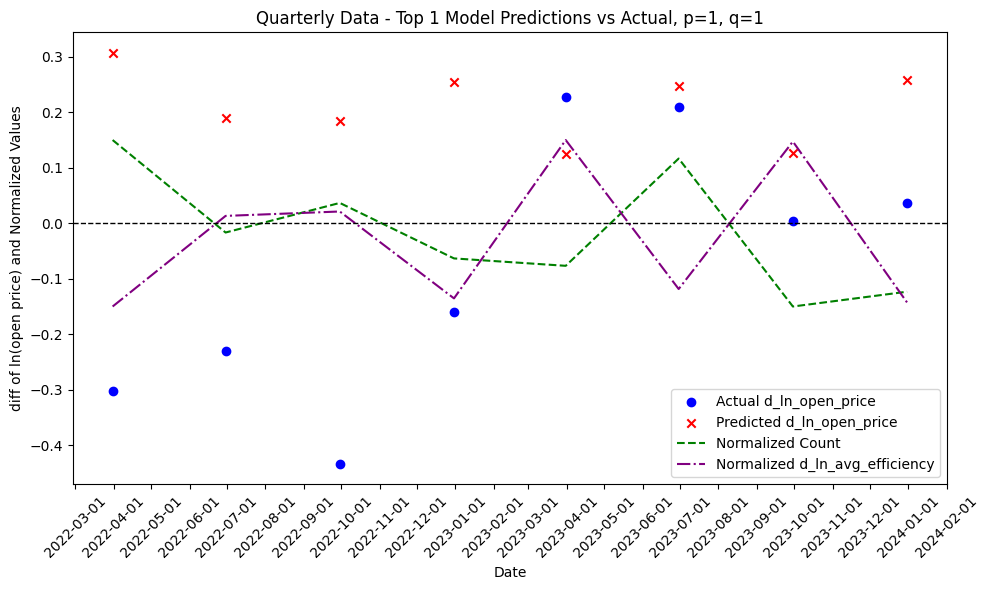

Top 2 Model: ARIMA(1,0,2), MAE: 0.25831921393637536
{'MSE': 0.1436047514460396, 'RMSE': 0.37895217567133666, 'AIC': 20.402989299971335, 'BIC': 28.396216361022557, 'Ljung-Box': 0.29178429907618864, 'Durbin-Watson': 1.785376374895295, 'Jarque-Bera': 0.12132151623100733, 'Shapiro-Wilk': 0.02652931958436966, 'White Test': 0.3916765128821888}


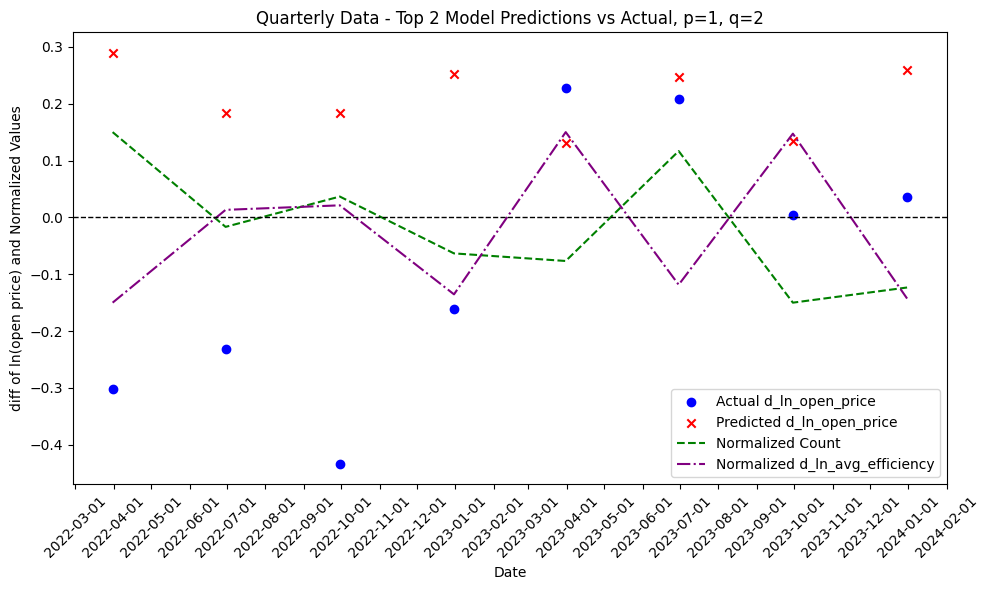

Top 3 Model: ARIMA(1,0,4), MAE: 0.2706306094436782
{'MSE': 0.14890981603355363, 'RMSE': 0.3858883465894683, 'AIC': 23.374882868251127, 'BIC': 34.032518949652754, 'Ljung-Box': 0.4691057776550821, 'Durbin-Watson': 1.8998764097944383, 'Jarque-Bera': 0.20362536160636252, 'Shapiro-Wilk': 0.04177171736955643, 'White Test': 0.5620856371605546}


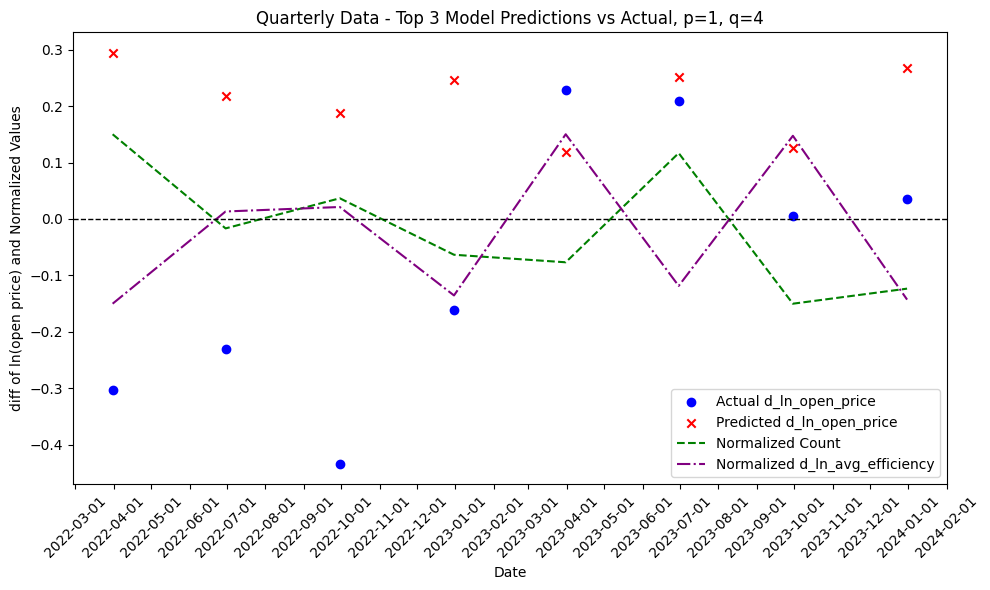

In [24]:
print("Quarterly Data Model Estimation:")
model_estimation(quarterly_data, range(1, 5, 1), range(1, 5, 1), title='Quarterly Data', ratio=0.8)
results_df

In [19]:
print("Stationarity Check for Quarterly Data:")
check_stationarity(quarterly_data['d_ln_open_price'])
check_stationarity(quarterly_data['d_ln_avg_efficiency'])

Stationarity Check for Quarterly Data:
ADF Statistic: -3.775273
p-value: 0.003171
Series is stationary
ADF Statistic: -8.339243
p-value: 0.000000
Series is stationary


Distribution Plot:


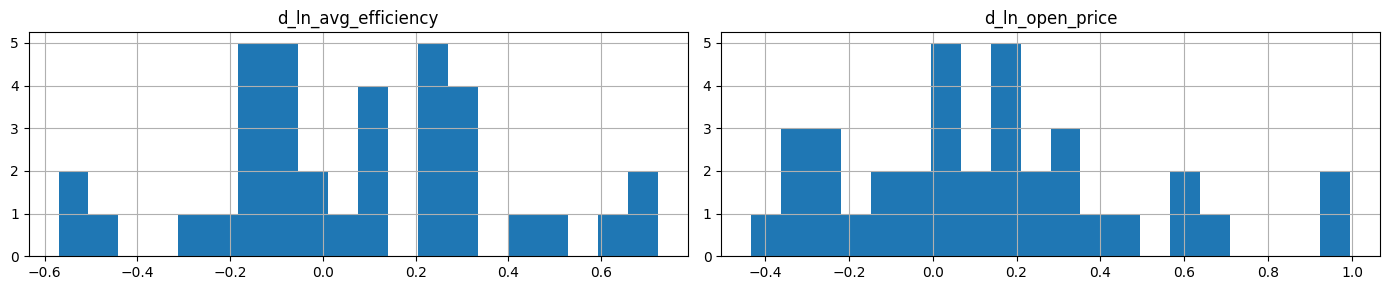

Summary Statistics:
ACF and PACF Plots for d_ln_avg_efficiency:


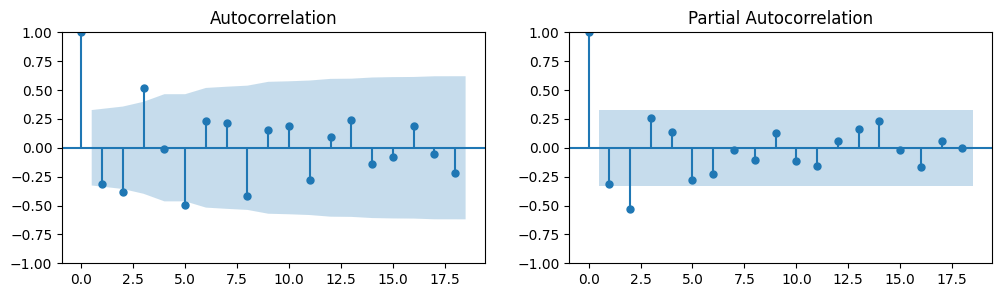

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
d_ln_avg_efficiency,36.0,0.073419,0.315846,-0.569873,-0.136739,0.077264,0.273398,0.721643,0.075130,-0.140035
d_ln_open_price,36.0,0.130219,0.346101,-0.433166,-0.114683,0.100708,0.290912,0.995362,0.748462,0.523040


In [29]:
exploratory_analysis(quarterly_data)

In [25]:
perform_cointegration_test(quarterly_data, 'd_ln_open_price', 'd_ln_avg_efficiency')

Co-integration test results for d_ln_open_price and d_ln_avg_efficiency:
t-statistic: -3.638660237284447
p-value: 0.02192804059767351
Critical values: [-4.23672041 -3.51627408 -3.16784755]
The series are likely co-integrated.


(-3.638660237284447,
 0.02192804059767351,
 array([-4.23672041, -3.51627408, -3.16784755]))

# Monthly

Monthly Data Model Estimation:
Top 1 Model: ARIMA(2,0,2), MAE: 0.20644038264864864
{'MSE': 0.020329986098496265, 'RMSE': 0.14258326023238585, 'AIC': -33.821856260526594, 'BIC': -14.375321869780088, 'Ljung-Box': 0.7819654284628552, 'Durbin-Watson': 1.9914868067714582, 'Jarque-Bera': 0.7568935485924921, 'Shapiro-Wilk': 0.9589343667030334, 'White Test': 0.9312501390699206}


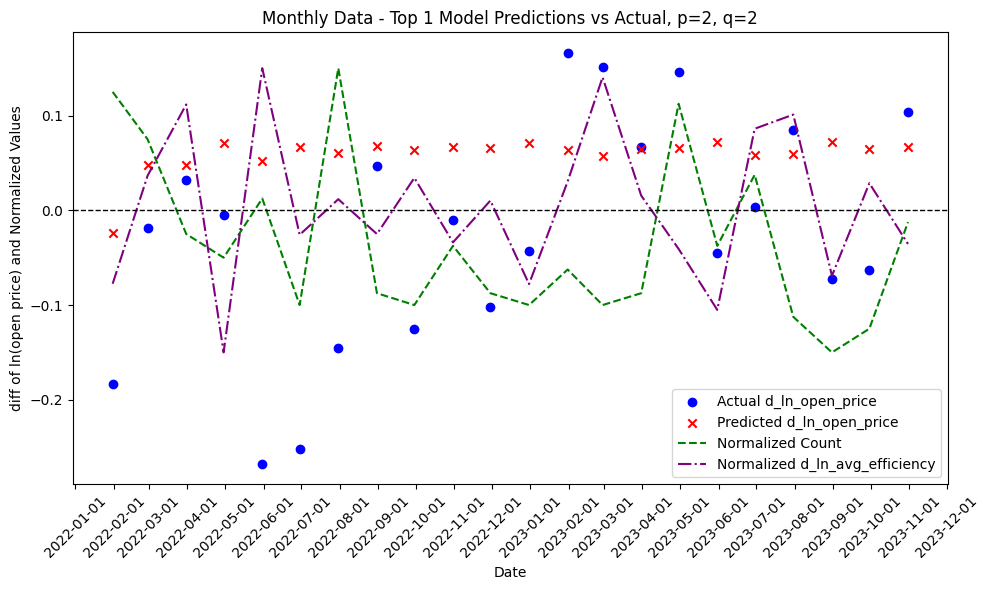

Top 2 Model: ARIMA(3,0,4), MAE: 0.21521794391353827
{'MSE': 0.021469990127298947, 'RMSE': 0.14652641443541484, 'AIC': -29.507174184436387, 'BIC': -2.7681893971599365, 'Ljung-Box': 0.9225290931351106, 'Durbin-Watson': 1.9606644595556593, 'Jarque-Bera': 0.5266570157029082, 'Shapiro-Wilk': 0.7887036800384521, 'White Test': 0.9097982657401577}


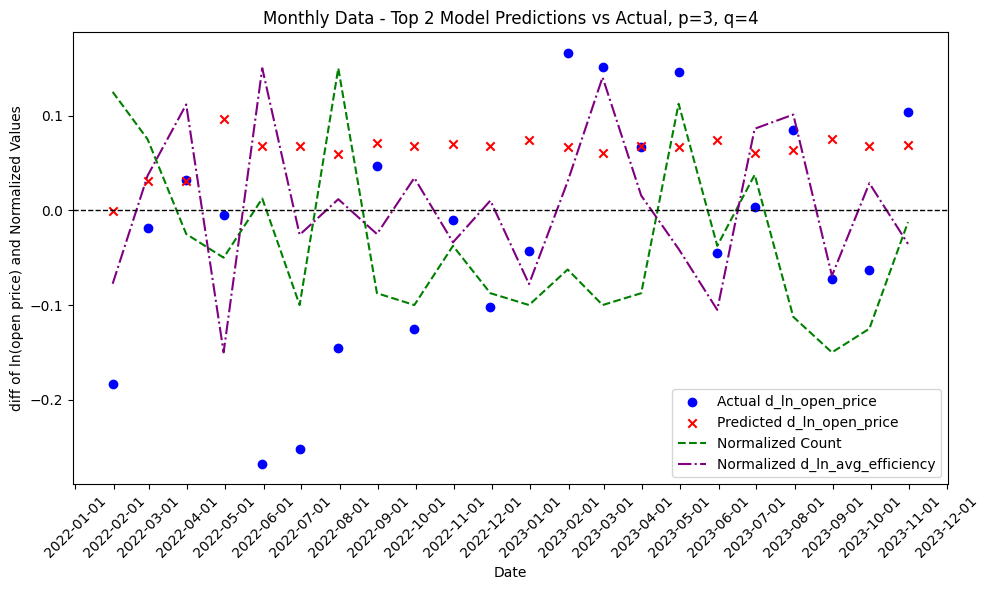

Top 3 Model: ARIMA(3,0,2), MAE: 0.21610202833582187
{'MSE': 0.020616818465373384, 'RMSE': 0.1435855788906859, 'AIC': -32.937426758587875, 'BIC': -11.060075568998059, 'Ljung-Box': 0.8845997332253741, 'Durbin-Watson': 1.8911137363852089, 'Jarque-Bera': 0.9878981714648062, 'Shapiro-Wilk': 0.943208634853363, 'White Test': 0.7590797460025702}


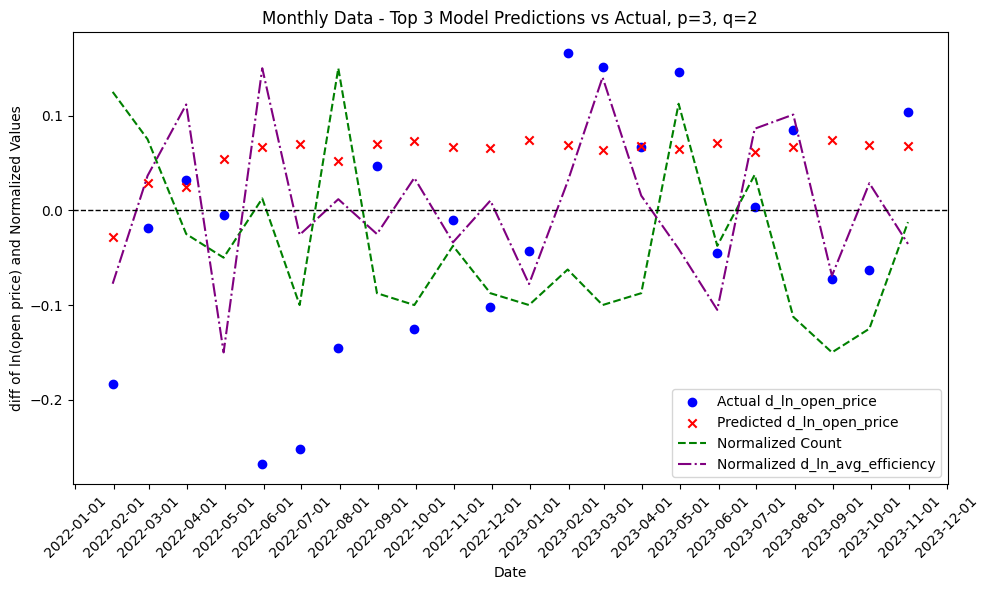

In [3]:
print("Monthly Data Model Estimation:")
model_estimation(monthly_data, range(2, 6, 1), range(2, 6, 1), title='Monthly Data', ratio=0.8)
# model_estimation(monthly_data, range(4, 7, 1), range(4, 7, 1), title='Monthly Data', ratio=0.8)
# model_estimation(monthly_data, range(1, 3, 1), range(1, 3, 1), title='Monthly Data', ratio=0.8)
results_df

In [4]:
print("Stationarity check for monthly data")
check_stationarity(monthly_data['d_ln_open_price'])
check_stationarity(monthly_data['d_ln_avg_efficiency'])

Stationarity check for monthly data
ADF Statistic: -6.910087
p-value: 0.000000
Series is stationary
ADF Statistic: -6.329888
p-value: 0.000000
Series is stationary


Distribution Plot:


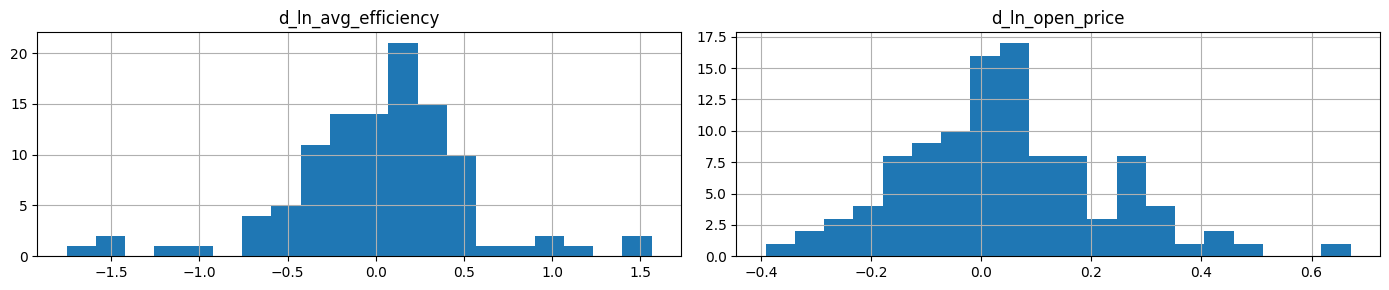

Summary Statistics:
ACF and PACF Plots for d_ln_avg_efficiency:


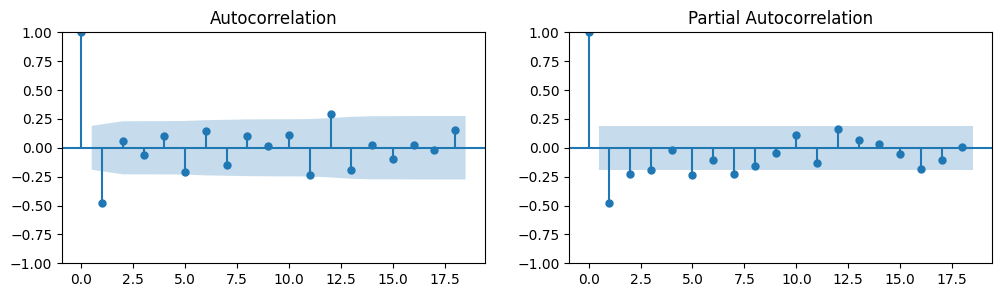

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
d_ln_avg_efficiency,106.0,0.026007,0.510695,-1.753218,-0.194914,0.071373,0.317619,1.564512,-0.488120,2.634543
d_ln_open_price,106.0,0.044073,0.182874,-0.391159,-0.070248,0.034404,0.145015,0.671024,0.440641,0.789578


In [30]:
exploratory_analysis(monthly_data)

In [6]:
perform_cointegration_test(monthly_data, 'd_ln_open_price', 'd_ln_avg_efficiency')

Co-integration test results for d_ln_open_price and d_ln_avg_efficiency:
t-statistic: -6.959885964112277
p-value: 1.0689059365972825e-08
Critical values: [-4.00378481 -3.39494029 -3.08508909]
The series are likely co-integrated.


(-6.959885964112277,
 1.0689059365972825e-08,
 array([-4.00378481, -3.39494029, -3.08508909]))

# Weekly

Weekly Data Model Estimation:


Top 1 Model: ARIMA(1,0,1), MAE: 0.07754912056942347
{'MSE': 0.004644172683884847, 'RMSE': 0.06814816713518308, 'AIC': -818.8392718802872, 'BIC': -795.3907742512737, 'Ljung-Box': 0.34443070368837936, 'Durbin-Watson': 1.9870245742056836, 'Jarque-Bera': 0.0022299623085157445, 'Shapiro-Wilk': 0.0011682459153234959, 'White Test': 0.48297055136895417}


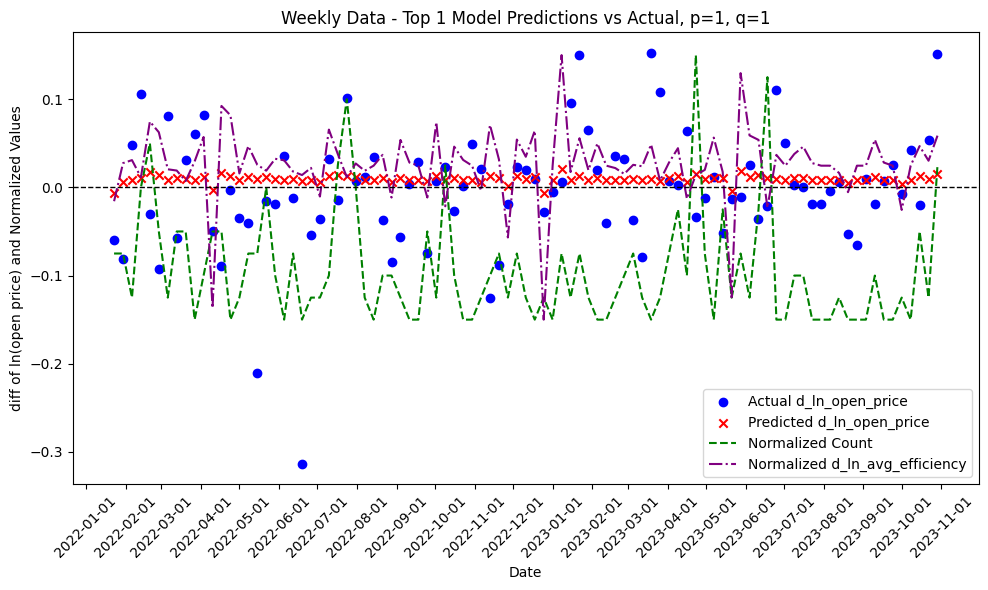

Top 2 Model: ARIMA(1,0,2), MAE: 0.08101534816650426
{'MSE': 0.004655182232961806, 'RMSE': 0.06822889587969166, 'AIC': -817.0873798646855, 'BIC': -789.730799297503, 'Ljung-Box': 0.38730212532672126, 'Durbin-Watson': 1.9899500637220409, 'Jarque-Bera': 0.0018135499503522247, 'Shapiro-Wilk': 0.0009764282731339335, 'White Test': 0.49313829112486307}


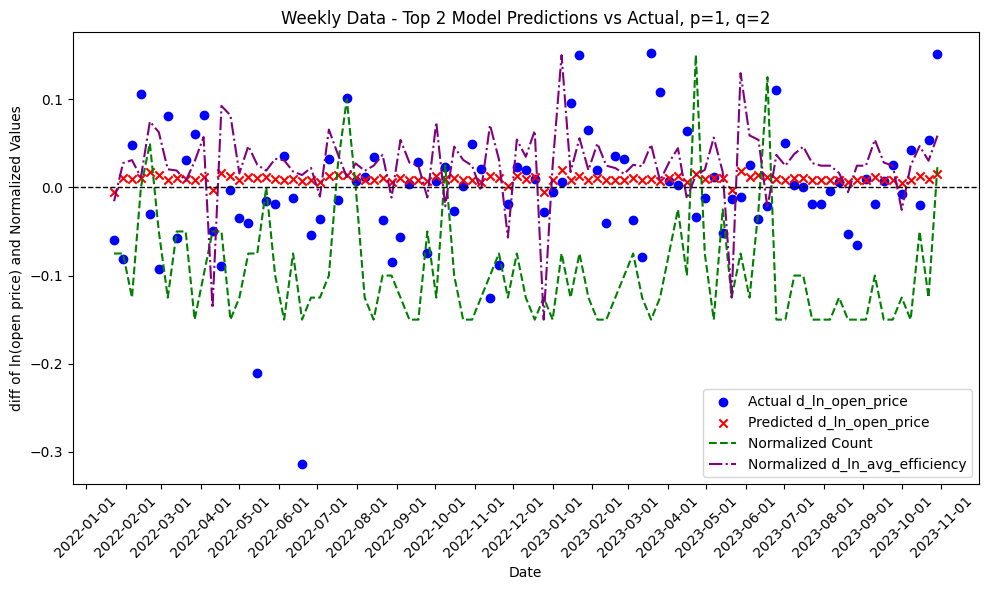

Top 3 Model: ARIMA(2,0,2), MAE: 0.0908912107856238
{'MSE': 0.004652254329564817, 'RMSE': 0.06820743602837463, 'AIC': -815.369337141962, 'BIC': -784.1046736366105, 'Ljung-Box': 0.4114815574691289, 'Durbin-Watson': 1.9924552674569913, 'Jarque-Bera': 0.0018440949395737152, 'Shapiro-Wilk': 0.0008941215346567333, 'White Test': 0.5076310206361043}


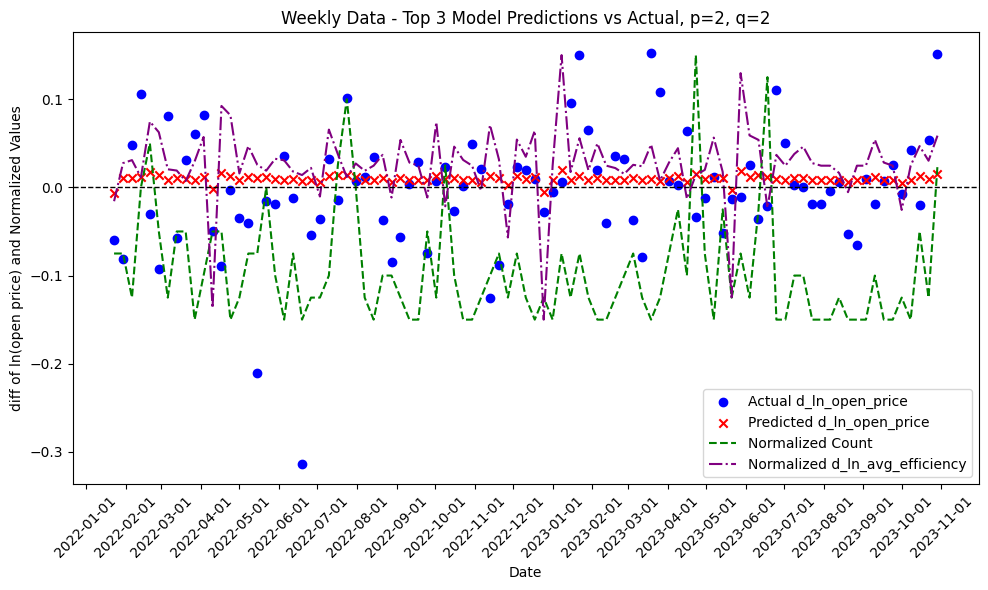

In [7]:
print("Weekly Data Model Estimation:")
# model_estimation(weekly_data, range(1, 6, 1), range(1, 6, 1), title='Weekly Data', ratio=0.8)
model_estimation(weekly_data, range(1, 3, 1), range(1, 3, 1), title='Weekly Data', ratio=0.8)
results_df

In [8]:
print("Stationarity check for weekly data")
check_stationarity(weekly_data['d_ln_open_price'])
check_stationarity(weekly_data['d_ln_avg_efficiency'])

Stationarity check for weekly data
ADF Statistic: -15.002441
p-value: 0.000000
Series is stationary
ADF Statistic: -7.969454
p-value: 0.000000
Series is stationary


Distribution Plot:


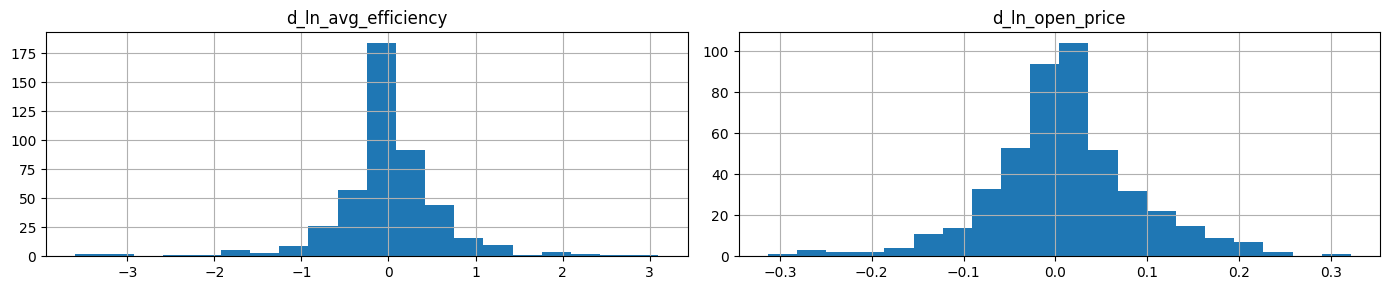

Summary Statistics:
ACF and PACF Plots for d_ln_avg_efficiency:


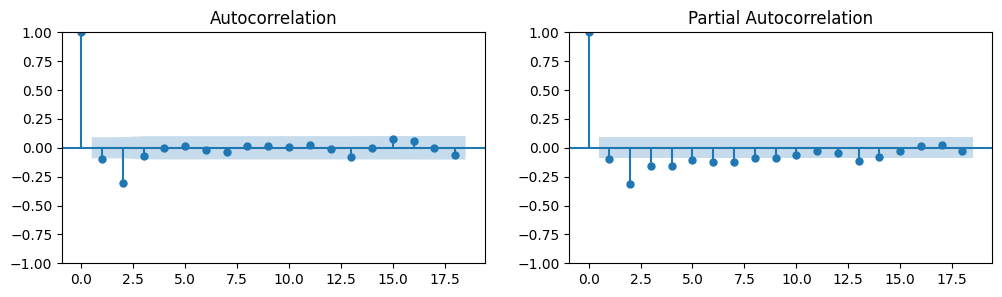

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
d_ln_avg_efficiency,461.0,0.008091,0.659471,-3.598365,-0.194234,0.000000,0.273292,3.100336,-0.684736,7.325169
d_ln_open_price,461.0,0.009966,0.081107,-0.313285,-0.030217,0.007147,0.049662,0.321963,-0.049507,1.764682


In [31]:
exploratory_analysis(weekly_data)

In [10]:
perform_cointegration_test(weekly_data, 'd_ln_open_price', 'd_ln_avg_efficiency')

Co-integration test results for d_ln_open_price and d_ln_avg_efficiency:
t-statistic: -15.017830656644332
p-value: 8.777730157970857e-27
Critical values: [-3.92040692 -3.34944507 -3.05368285]
The series are likely co-integrated.


(-15.017830656644332,
 8.777730157970857e-27,
 array([-3.92040692, -3.34944507, -3.05368285]))

# Daily

Daily Data Model Estimation:
Top 1 Model: ARIMA(1,0,1), MAE: 0.041202046283640964
{'MSE': 0.0008676559627401837, 'RMSE': 0.029456000453900455, 'AIC': -9306.9891764776, 'BIC': -9271.858234442312, 'Ljung-Box': 0.07207913470758663, 'Durbin-Watson': 1.9964238002116221, 'Jarque-Bera': 0.0, 'Shapiro-Wilk': 4.3381005494997676e-39, 'White Test': 0.5263318567062365}


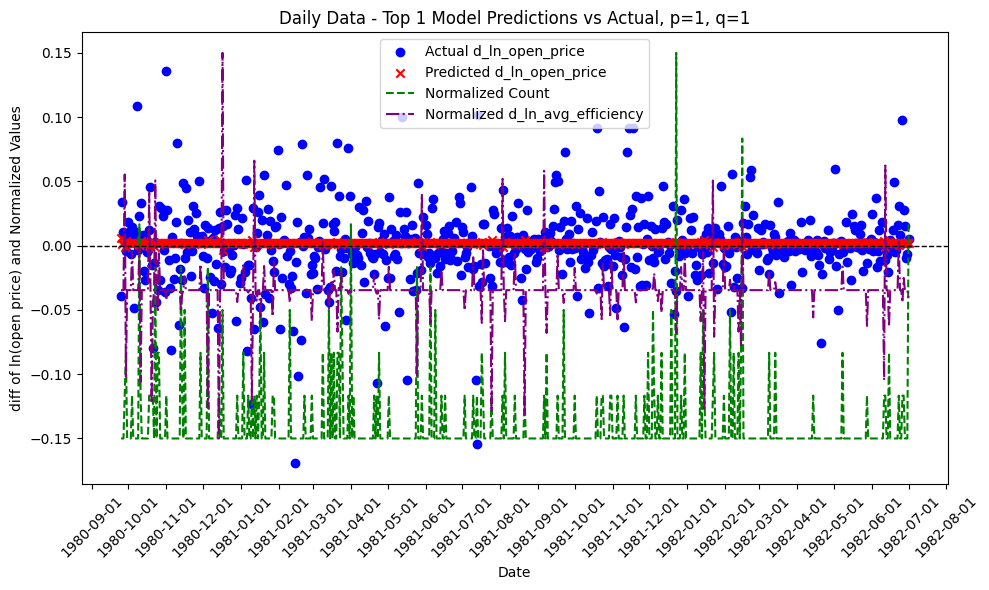

Top 2 Model: ARIMA(1,0,2), MAE: 0.04422457761333012
{'MSE': 0.000862328409971423, 'RMSE': 0.029365428823216987, 'AIC': -9302.172460261108, 'BIC': -9261.18636121994, 'Ljung-Box': 0.1322744043468486, 'Durbin-Watson': 2.0022402030152255, 'Jarque-Bera': 0.0, 'Shapiro-Wilk': 4.0562629945639744e-39, 'White Test': 0.49909689626843934}


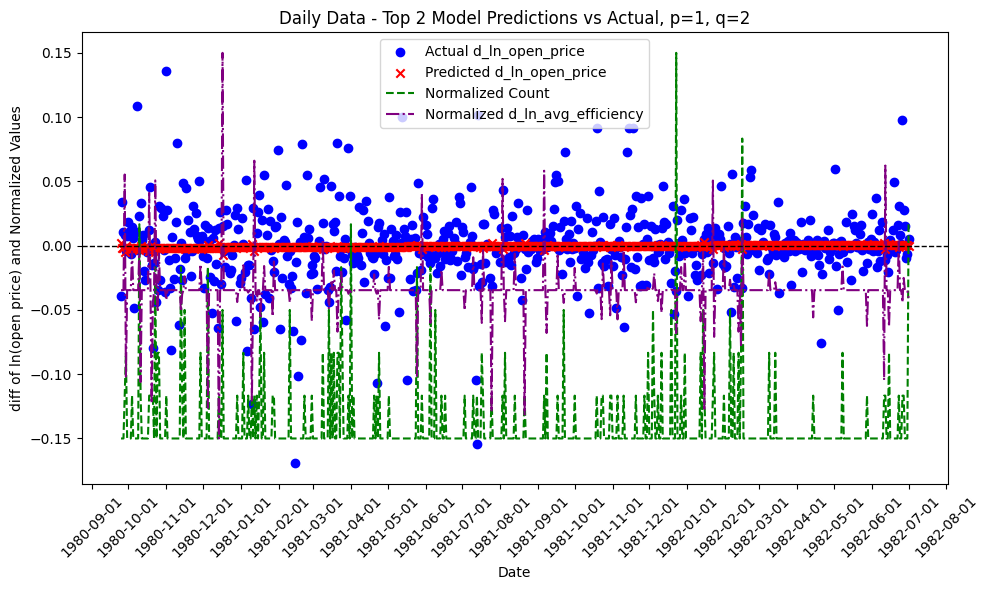

Top 3 Model: ARIMA(2,0,1), MAE: 0.04670622920296358
{'MSE': 0.0008677282677413714, 'RMSE': 0.029457227767415103, 'AIC': -9305.075976283842, 'BIC': -9264.089877242674, 'Ljung-Box': 0.07246301609206672, 'Durbin-Watson': 1.9968487852100547, 'Jarque-Bera': 0.0, 'Shapiro-Wilk': 4.414156023650997e-39, 'White Test': 0.526195163614615}


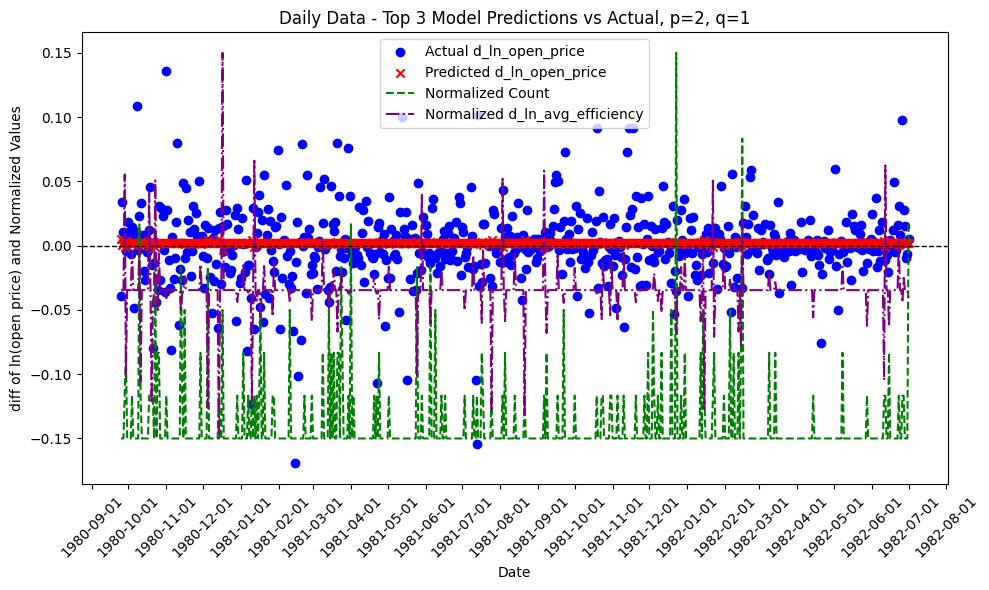

In [11]:
print("Daily Data Model Estimation:")
# model_estimation(daily_data, range(1, 6, 1), range(1, 6, 1), title='Daily Data', ratio=0.8)
model_estimation(daily_data, range(1, 3, 1), range(1, 3, 1), title='Daily Data', ratio=0.8)

In [12]:
print("Stationarity check for daily data")
check_stationarity(daily_data['d_ln_open_price'])
check_stationarity(daily_data['d_ln_avg_efficiency'])

Stationarity check for daily data
ADF Statistic: -58.450362
p-value: 0.000000
Series is stationary
ADF Statistic: -18.393440
p-value: 0.000000
Series is stationary


Distribution Plot:


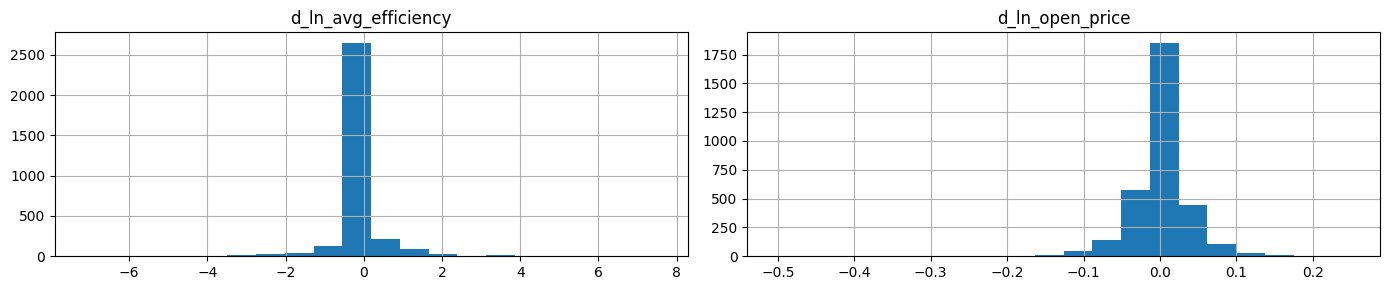

Summary Statistics:
ACF and PACF Plots for d_ln_avg_efficiency:


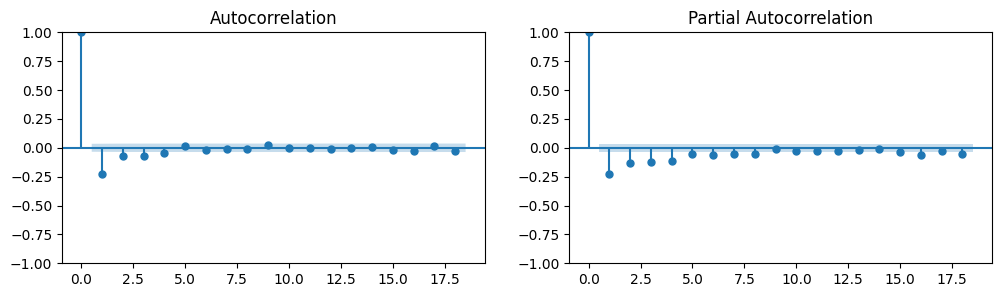

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
d_ln_avg_efficiency,3224.0,0.001064,0.691332,-7.163968,0.00000,0.000000,0.000000,7.542935,0.345700,25.665397
d_ln_open_price,3224.0,0.001442,0.037920,-0.502367,-0.01247,0.001337,0.016709,0.250182,-0.920692,13.978189


In [32]:
exploratory_analysis(daily_data)

In [14]:
perform_cointegration_test(daily_data, 'd_ln_open_price', 'd_ln_avg_efficiency')

Co-integration test results for d_ln_open_price and d_ln_avg_efficiency:
t-statistic: -58.46080349483251
p-value: 0.0
Critical values: [-3.89984127 -3.33802644 -3.04576618]
The series are likely co-integrated.


(-58.46080349483251, 0.0, array([-3.89984127, -3.33802644, -3.04576618]))